11443843 Chung Ki Ki

Dataset source: The testing video was taken by me while I was trevelling

In [30]:
# Install libraries
!pip install opencv-python opencv-python-headless
!pip install torch torchvision
!pip install filterpy scikit-learn
!pip install py-sort


ERROR: Could not find a version that satisfies the requirement py-sort (from versions: none)
ERROR: No matching distribution found for py-sort


In [31]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
!git clone https://github.com/abewley/sort.git
%cd sort

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/INT4097_TakeHome/yolov5
fatal: destination path 'sort' already exists and is not an empty directory.
/content/drive/MyDrive/INT4097_TakeHome/yolov5/sort


In [32]:
#Import libraries
# import the cv2 library
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive
import os
import csv
import numpy as np
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from IPython.display import display, clear_output



In [33]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/INT4097_TakeHome/')# Change this path to your workplace, where you will see the tracked_output.mp4 at the end

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Upload your video here

# Allow the user to upload a file
uploaded = files.upload()

# Get the name of the uploaded file
video_file = next(iter(uploaded.keys()))

print(f"Uploaded file: {video_file}")

Saving Walkingsolder.mp4 to Walkingsolder (1).mp4
Uploaded file: Walkingsolder (1).mp4


In [35]:


# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-5 Python-3.11.11 torch-2.5.1+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 132MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Video file opened successfully!


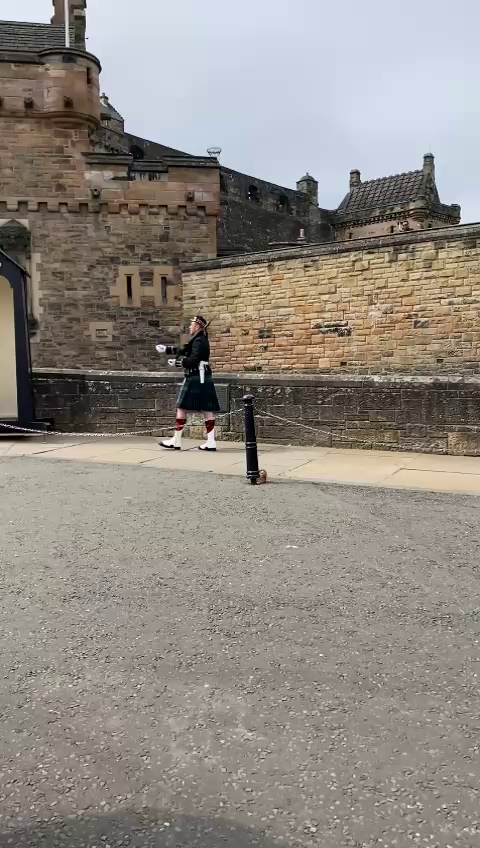

In [36]:
# Read the video
# Open the video file
cap = cv2.VideoCapture(video_file)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Video file opened successfully!")

# Read the first frame to confirm reading
ret, frame = cap.read()

if ret:
    # Display the frame using cv2_imshow
    cv2_imshow(frame)
else:
    print("Error: Could not read the frame.")

# Release the video capture object
cap.release()

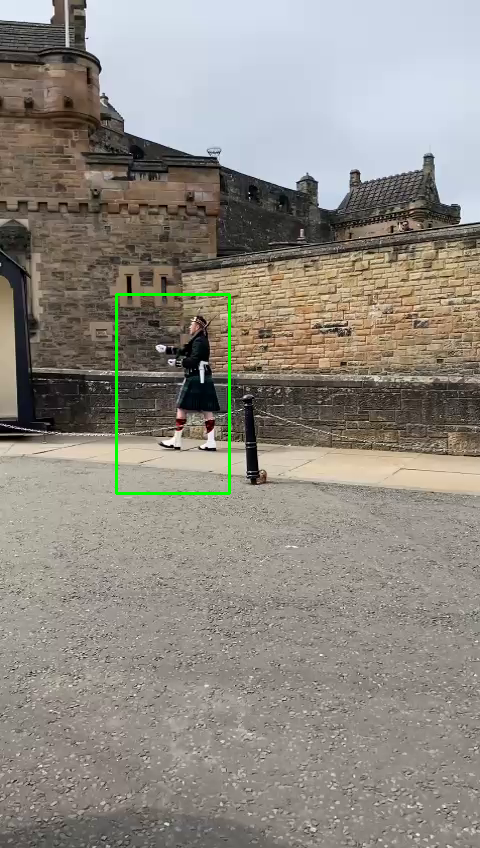

IntSlider(value=116, description='X', max=479)

IntSlider(value=294, description='Y', max=847)

IntSlider(value=113, description='Width', max=480, min=1)

IntSlider(value=199, description='Height', max=848, min=1)

In [37]:
#Create tracking

cap = cv2.VideoCapture(video_file)
ret, first_frame = cap.read()
if not ret:
    print("Error reading video.")
    cap.release()
    exit()

frame_height, frame_width = first_frame.shape[:2]

# Create sliders to let the user select bounding box
x_slider = widgets.IntSlider(min=0, max=frame_width - 1, value=50, description='X')
y_slider = widgets.IntSlider(min=0, max=frame_height - 1, value=50, description='Y')
w_slider = widgets.IntSlider(min=1, max=frame_width, value=100, description='Width')
h_slider = widgets.IntSlider(min=1, max=frame_height, value=100, description='Height')
display(x_slider, y_slider, w_slider, h_slider)

def update_display(change):
    """
    This callback is triggered whenever a slider value changes.
    It draws a rectangle on the first frame and re-displays it.
    """
    # Copy the first frame so we can draw on it
    frame_copy = first_frame.copy()

    # Read current slider values
    x = x_slider.value
    y = y_slider.value
    w = w_slider.value
    h = h_slider.value

    # Draw the bounding box on the copy
    cv2.rectangle(frame_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Clear the previous output in this cell and show the updated image
    clear_output(wait=True)
    cv2_imshow(frame_copy)

    # Re-display the sliders so they remain visible
    display(x_slider, y_slider, w_slider, h_slider)

# Attach the callback function to each slider
x_slider.observe(update_display, names='value')
y_slider.observe(update_display, names='value')
w_slider.observe(update_display, names='value')
h_slider.observe(update_display, names='value')



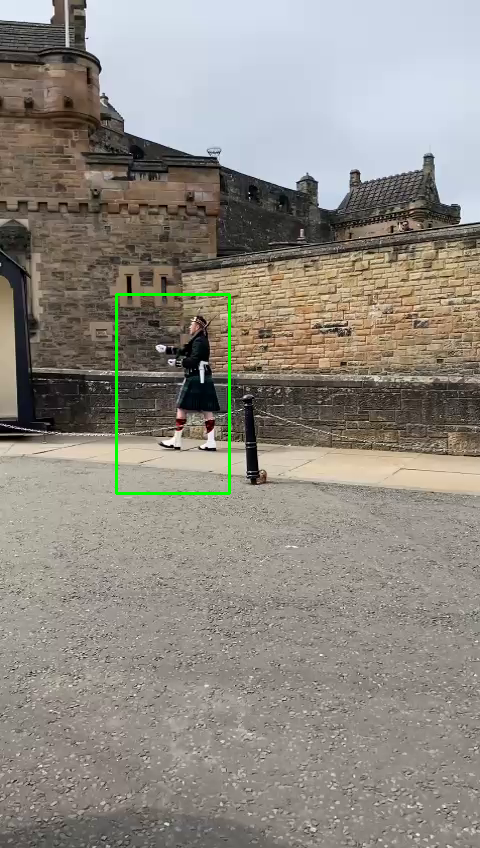

IntSlider(value=116, description='X', max=479)

IntSlider(value=294, description='Y', max=847)

IntSlider(value=113, description='Width', max=480, min=1)

IntSlider(value=199, description='Height', max=848, min=1)

In [40]:
# Initially display the bounding box and sliders
update_display(None)  # After running this, run the previous code upper again, you should see the box now

In [41]:
# Read the final slider values
x, y = x_slider.value, y_slider.value
w, h = w_slider.value, h_slider.value
bbox = (x, y, w, h)

# Initialize OpenCV's CSRT tracker
tracker = cv2.legacy.TrackerCSRT_create()
tracker.init(first_frame, bbox)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    success, bbox = tracker.update(frame)
    if success:
        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    else:
        cv2.putText(frame, "Tracking failure", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)



cap.release()


In [43]:
# Create the tracking video
# 1) Initialize the Box position

cap = cv2.VideoCapture(video_file)
x = x_slider.value
y = y_slider.value
w = w_slider.value
h = h_slider.value
bbox = (x, y, w, h)


# 2) Initialize the CSRT tracker

tracker = cv2.legacy.TrackerCSRT_create()
tracker.init(first_frame, bbox)

# ========================================
# 3) Prepare to write bounding box data to CSV
#    and create a VideoWriter to save the output video
# ========================================
# Get the original video’s properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create VideoWriter (MP4)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('tracked_output.mp4', fourcc, fps, (frame_width, frame_height))

# Open CSV file for writing bounding box data
csv_filename = 'tracking_data.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['frame_index', 'x', 'y', 'width', 'height'])  # Header row

    frame_index = 0
    # We already read the first frame above, so let's process it separately
    success, bbox = tracker.update(first_frame)
    if success:
        x, y, w, h = [int(v) for v in bbox]
        # Write the bounding box to CSV
        writer.writerow([frame_index, x, y, w, h])
        # Draw the box
        cv2.rectangle(first_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    else:
        cv2.putText(first_frame, "Tracking failure", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    # Write the annotated first frame to video
    out.write(first_frame)
    frame_index += 1

    # ========================================
    # 4) Loop through the rest of the frames
    # ========================================
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        success, bbox = tracker.update(frame)
        if success:
            x, y, w, h = [int(v) for v in bbox]
            # Record bounding box in CSV
            writer.writerow([frame_index, x, y, w, h])
            # Draw the bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        else:
            cv2.putText(frame, "Tracking failure", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        # Write frame (with or without box) to the output video
        out.write(frame)

        frame_index += 1

cap.release()
out.release()


